

# Lab 1: Estimating Basin Waterbalance




<p style="height:1pt"> </p>

<div class="boxhead1">
    Lab 1 Contents
</div>

<div class="boxtext1">
<ul class="a">
     <li> 📌 Instructions </li>
     <li> 📌 Setting up the Lab </li>
    <li> 📌 Background </li>
    <li> 📌 Lab Assignment </li>
</ul>

</div>

<hr style="border-top: 0.2px solid gray; margin-top: 12pt; margin-bottom: 0pt"></hr>

## 1. Instructions
Work through the exercise, writing code where indicated. To run a cell, click on the cell and press "Shift" + "Enter" or click the "Run" button in the toolbar at the top. Note: Do not restart the kernel and clear all outputs. If this happens, run the last cell in the notebook before proceeding.

<p style="color:#408000; font-weight: bold"> 🐍 &nbsp; &nbsp; This symbol designates an important note about Python structure, syntax, or another quirk.  </p>

<p style="color:#443823; font-weight: bold">📊 &nbsp; &nbsp; This symbol designates an important note about Environmental Data methods, sources, and access. </p>

<p style="color:#008C96; font-weight: bold"> ▶️ &nbsp; &nbsp; This symbol designates a cell with code to be run.  </p>

<p style="color:#008C96; font-weight: bold"> ✏️ &nbsp; &nbsp; This symbol designates a partially coded cell with an example.  </p>

<p style="color:#008C96; font-weight: bold"> 📚 &nbsp; &nbsp; This symbol designates a practice question.  </p>


<hr style="border-top: 1px solid gray; margin-top: 24px; margin-bottom: 1px"></hr>



## 2. Setting up the Lab

[`hydrodata`](https://hydrodata.readthedocs.io/en/latest/index.html) is a Python library designed to aid in  watershed analysis. Hydrodata is capable of downloading, preprocessing, and visualizing climatological, hydrological, and geographical datasets pertaining to a given watershed. Supported datasets include: Daymet climate, USGS streamflow, and data from the National Land Cover Dataset.

#### 2.1 Hydrodata

It's easy to use `hydrodata` to get streamflow data for any USGS gauge. In the background for this lab, we will be looking at some gauges across southern California. Your lab will focus on a stream gauge near to some favorite (or personally interesting) place in the U.S.

```python
from hydrodata import Station
import hydrodata.datasets as hds


```

<div class="run">
    ▶️ <b> Run the cell below. </b>
</div>

In [9]:
import pandas as pd
from hydrodata import Station
import hydrodata.datasets as hds
%matplotlib inline
import warnings
warnings.filterwarnings("ignore") # Don't output warnings

## 3. Background

This lab is going to give you some first exposure to doing analysis in `pandas` and creating your own Jupyter notebooks for presenting results and information. The main concept we will be considering is mass balance. Along with energy and momentum, mass is one of the three consitutents that are conserved in environmental systems. More generally, physical systems can be written as a statement of mass, energy, or momentum. The key to creating these statements (or equations) of balance is determining the bounds of the system (its geographic extent and structure) as well as the specific processes acting across those boundaries. 

Let's take a look at a typical river basin, the upper portions of the Sisquoc River, which is a westward flowing river in northeastern Santa Barbara County, California. The Sisquoc is a tributary of the Santa Maria River, which is formed when the Sisquoc River meets the Cuyama River at the Santa Barbara County and San Luis Obispo County border just north of Garey. The river is 57.4 miles (92.4 km) long and originates on the north slopes of Big Pine Mountain, at approximately 6,320 feet (1,930 m). Big Pine Mountain is part of the San Rafael Mountains, which are part of the Transverse Ranges. Sisquoc is the Chumash word meaning "quail" and the Sisquoc River is a designated National Wild and Scenic River managed by the US Forest Service.

We can use the [`hydrodata`](https://hydrodata.readthedocs.io/en/latest/usage.html) library `Station` object, which we imported earlier. To create an instance of the `Station` class, we need to specify a USGS `station_id`, which is a unique code that identifies each of the USGS gauging locations across the United States. In addition, we need to specify a `start` and an`end` date for our data request. These dates are used to determine what streamflow data to collect, as well as other meteorological data, which we will see later in the background section. 

For this lab, we will be looking at the 2016, 2017, and 2018 water years. Water years are a bit like school years - they start in the fall instead of on January 1st. Specifically, a single water year begins on October 1 and ends on September 30th of the following year. Water years are designated by the calendar years in which they *end* (e.g. WY 2015 began on October 1, 2014 and ended on September 30, 2015). Therefore, we will start our collection on the 1st of October 2015 and end our data on September 30, 2018.

```python
station_id = '11138500'  # This is a USGS station ID. Later, I will show you how to find one on your own!
start = '2015-10-01'     # Start date is the Oct. 1, 2015 which is the start of the 2016 water year.
end = '2018-09-30'       # End date is the Sept 30, 2018 which is the end of the 2018 water year.

# Create our watershed object using the station_id, start, and end dates
wshed = Station(start=start, end=end, station_id=station_id, data_dir="data/")
```
<div class="run">
    ▶️ <b> Run the cell below. </b>
</div>

In [10]:
station_id = '11138500'  # This is a USGS station ID. Later, I will show you how to find one on your own!
start = '2015-10-01'     # Start date is the Oct. 1, 2015 which is the start of the 2016 water year.
end = '2018-09-30'       # End date is the Sept 30, 2018 which is the end of the 2018 water year.

# Create our watershed object using the station_id, start, and end dates
wshed = Station(start=start, end=end, station_id=station_id, data_dir="../data/lab_1/")

## 3.1 Visualizing watersheds

A watershed (or catchment, or drainage basin) is any area of land where precipitation collects and drains off into a common outlet, such as into a river, bay, or other body of water. The watershed includes all the surface water from rain, runoff, snowmelt, hail, sleet and nearby streams that run downslope towards the shared outlet, as well as the groundwater underneath the Earth's surface. Watersheds are hierarchical, which means they connect into other watersheds at lower elevations, with smaller sub-drainage basins, which in turn drain into another common outlet. This pattern of self-similar, hierarchical structures means that watersheds and their associated stream networks form a stochastic fractal network that collectively routes water and sediment over the Earth's surface. Visualizing a watershed requires defining an outlet, which identifies the lowest point of the catchment and the location through which all surface water drains. In this lab, we will define the outlet of a watershed as the location of a USGS streamflow gauge. By linking the definition of our watersheds to the location of streamflow gauges, we will be able to examine the mass balance of the watershed. Before diving into the principles of mass balance as they apply to watersheds, let's first spend a little time learning how to acquire and visualize watersheds based on the location of a USGS streamgauge.


### 3.1.1 Viewing Watershed Hydrography 

We can use some of the dataset interfaces provided by `hydrodata` to map the stream channels within our watershed. 

<div class="data">
    📊 <b>HNDPlus</b>: The best source for hydrography data is the National Hydrography Dataset known as <a href="https://www.usgs.gov/core-science-systems/ngp/national-hydrography/nhdplus-high-resolution">NHDPlus</a>. The NHDPlus High Resolution (HR) is a national, geospatial model of the flow of water across the landscape and through the stream network. The NHDPlus HR is built using the National Hydrography Dataset High Resolution data at 1:24,000 scale or better, the 1/3 arc-second (10 meter ground spacing) 3D Elevation Program data, and the nationally complete Watershed Boundary Dataset. 
</div>

Access to the NHDPlus dataset is provided by the `NLDI` object, which is part of `hydrodata`'s `datasets` class, which we imported earlier as `hds`. To query these datasets, we use the following code:

```python
# Find the hydrography associated with this station using the wshed.station_id:
tributaries = hds.NLDI.tributaries(wshed.station_id)
main_channel = hds.NLDI.main(wshed.station_id)
stations = hds.NLDI.stations(wshed.station_id)
```
<div class="run">
    ▶️ <b> Run the cell below. </b>
</div>

In [11]:
# Find the hydrography associated with this station using the wshed.station_id:
tributaries = hds.NLDI.tributaries(wshed.station_id)
main_channel = hds.NLDI.main(wshed.station_id)
stations = hds.NLDI.stations(wshed.station_id)

We can then plot these data using internal `hydrodata` plotting functions, which are special versions of `matplotlib` plotting functions with extra features for viewing our stream channels.

```python

# Create a plot of the basin boundaries, main channel, tributaries, and station locations. 
ax = wshed.basin.plot(color='white', edgecolor='black', zorder=1, figsize = (10, 10))
tributaries.plot(ax=ax, label='Tributaries', zorder=2)
main_channel.plot(ax=ax, color='green', lw=3, label='Main', zorder=3)
stations.plot(ax=ax, color='black', label='All stations', marker='s', zorder=5)
ax.legend(loc='upper left');
ax.figure.set_dpi(100);
ax.set_title(u'Sisquoc River near Sisquoc, CA ({lon:.2f}\U000000b0W, {lat:.2f}\U000000b0N)'.format(
    lon=abs(my_station.lon),
    lat=my_station.lat))
```


<div class="python">
    🐍 <b>A Brief Aside About Python & Unicode.</b> In the code above, we include a <code>u</code> preceding the string in the <code>ax.set_title()</code> command. The letter <code>u</code> before a string is an indicatation that python should convert any <a href="https://en.wikipedia.org/wiki/Unicode"><code>unicode</code></a> symbols within the string when displaying it. In this case, we included <code>\U000000b0</code>, which is the unicode symbol for a degree sign (°), so our figure title will include these symbols when we run the code. 
    
You can find the most recent unicode definitions for over one hundred and fifty thousand written characters, symbols, and emojis at <a href="https://unicode-table.com/en/">https://unicode-table.com/en/</a>. Any of these Unicode representations can be expressed in a python string using an encoding that starts with a <code>\U</code> and is followed by exactly 8 values. Therefore, to use any unicode value in your python strings - for example, the smiling emoji, 😁, which is listed as unicode symbol <code>U+1F601</code> - you would include the unicode number (<code>1F601</code>) inside an 8-digit python unicode representation that would look like this: <code>\U0001F601</code>. The most common unicode symbols that were developed first, like the ° sign, only have 4 digits (<code>U+00b0</code>), so we must add 4 zeros before the symbol to get to a the 8-element representation that python requires: <code>\U000000b0</code>. 

</div>

<div class="run">
    ▶️ <b> Run the cell below. (Feel free to experiment with some unicode characters in the title!)</b>
</div>

Text(0.5, 1, 'Sisquoc River near Sisquoc, CA (120.17°W, 34.84°N)')

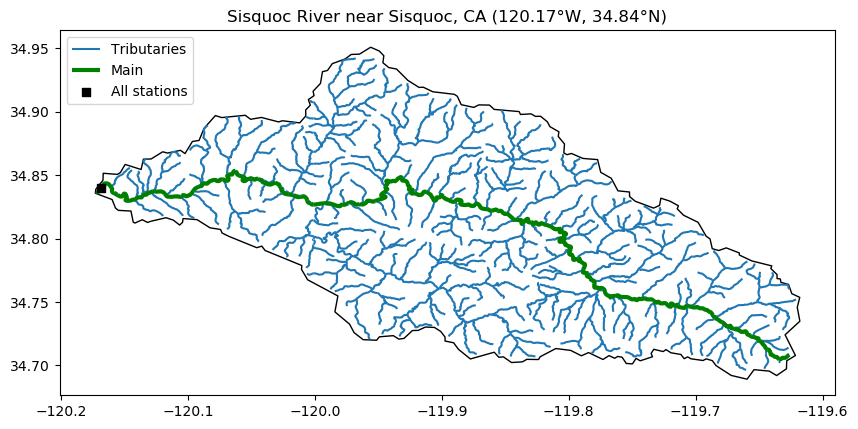

In [13]:
# Create a plot of the basin boundaries, main channel, tributaries, and station locations. 
ax = wshed.basin.plot(color='white', edgecolor='black', zorder=1, figsize = (10, 10))
tributaries.plot(ax=ax, label='Tributaries', zorder=2)
main_channel.plot(ax=ax, color='green', lw=3, label='Main', zorder=3)
stations.plot(ax=ax, color='black', label='All stations', marker='s', zorder=5)
ax.legend(loc='upper left');
ax.figure.set_dpi(100);
ax.set_title(u'Sisquoc River near Sisquoc, CA ({lon:.2f}\U000000b0W, {lat:.2f}\U000000b0N)'.format(
    lon=abs(wshed.lon),
    lat=wshed.lat))

In the map above, we can the main branch (green line) of the portion of the Sisquoc River above the town of Sisquoc, CA. The river is flowing in an East-West direction. You can also get a sense of the basin strucuture, which is very typical for a headwater river. There are many side tributaries that extend outward from the main branch, and the overall shape of the basin is such that it is widest just below the mid-point of the main branch. The fractal structure of the draininge network is very apparent. 

<div class="data">
    📊 <b> Fractal River Basins.</b>
If you'd like to learn more about the fractal geomoetry of river networks and their importance for governing mass and energy fluxes across the land surface, check out <a href="https://www.amazon.com/Fractal-River-Basins-Chance-Self-Organization/dp/0521004055">Fractal River Basins: Chance and Self-Organization</a> written by Ignacio Rodriguez-Iturbe and Andrea Rinaldo. 
</div>


### 3.1.2 Viewing Basin Topography Using Digital Elevation Data
We can get a better sense of this topography using Digital Elevation Data released by the USGS. 

<div class="data">
    📊 <b>National Elevation Dataset.</b> The National Elevation Dataset (NED) is a seamless raster product primarily derived from USGS 10- and 30-meter Digital Elevation Models (DEMs). NED data are available from The National Map Viewer as 1 arc-second (approximately 30 meters) for the CONUS, and at 1/3 and 1/9 arc-seconds (approximately 10 and 3 meters, respectively) for parts of the United States. The NED can be accessed through the <a href="https://www.usgs.gov/core-science-systems/national-geospatial-program/national-map">National Geospatial Program</a>. The next generation of US elevation data is being created as part of the <a href="https://www.usgs.gov/core-science-systems/ngp/3dep">3DEP</a> program. This program's goal is to complete acquisition of nationwide lidar (IfSAR in AK) by 2023 to provide the first-ever national baseline of consistent high-resolution elevation data – both bare earth and 3D point clouds – collected in a timeframe of less than a decade. 
</div>


The `hydrodata` library makes it easy to query the National Elevation Dataset to obtain 1 arc-second (~30 meter) digital elevation model (DEM) for any watershed in the United States. Because we already have our basin boundaries, we can make a targeted request to get only the elevation data inside our basin. Then we just make another figure that depicts the elevation data for our basin using a builtin method that is part of the class created by our data request:

```python

# Grab the watershed Digital Elevation Data from the USGS:
dem = hds.dem_bygeom(wshed.geometry, resolution=1)
dem.plot(size=8);

```
<div class="run">
    ▶️ <b> Run the cell below. </b>
</div>

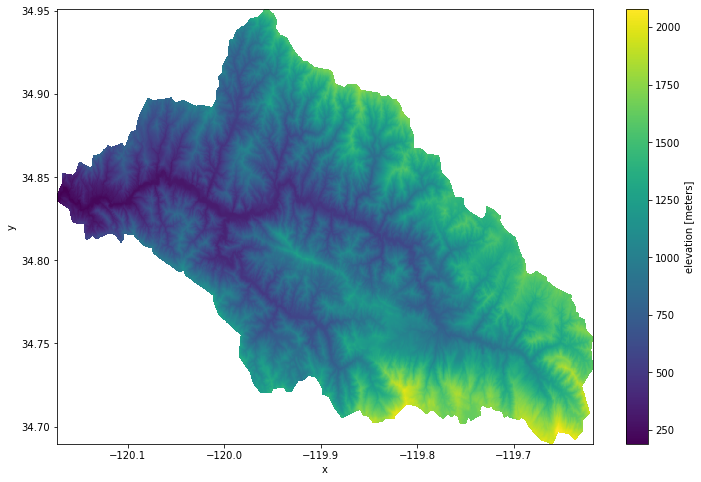

In [14]:
# Grab the watershed Digital Elevation Data from the USGS:
dem = hds.nationalmap_dem(wshed.geometry, resolution=1)
dem.plot(size=8);

## 3.2 A Catchment as a Physical System

In hydrological sciences, we use the idea of a catchment (or river basin) as the boundary of a system through which water flows. Because water has a relatively constant density (1 g H<sub>2</sub>O = 1 cm<sup>3</sup> H<sub>2</sub>O), we can measure water balance in terms of water volume (m<sup>3</sup>) in addition to water mass (10<sup>3</sup> kg). 



The water balance of a catchment is determined by the sum of inputs and outputs of water. If inputs are greater than outputs, the catchment is gaining water. If outputs are greater than inputs, the catchment is losing water. In the special case where outputs and inputs are equal, the catchment is neither gaining nor losing water, and the amount of water in the catchment is constant with time, meaning it is in _steady state_. 

The primary input of water into the land surface is through precipitation ($P$ [m<sup>3</sup>]). Precipitation usually takes the form of either rain or snow. There are two main ways that water exits a catchment: (1) the transport of water out of the catchment through streamflow (or river discharge); and (2) the transport of water back into the atmosphere in the form of vapor, which is released from either soils (evaporation, $E$ [m<sup>3</sup>]) or plants (transpiration, $T$ [m<sup>3</sup>]). For simplicity, we often combine evaporation and transpiration into a single quantity, evapotranspiration ($ET$). 

Having specified the important inputs and outputs, the change in storage of water in the catchment ($\Delta S$, [m<sup>3</sup>]) can be written as:

$$ \Delta S = P - ET - Q $$


In small basins, most of this stored water, $S$, is held in the soil. In larger basins, the storage of water in groundwater can be very important, as can the net movement of groundwater into and out of the basin. Finally, in basins where freezing conditions are common, large amounts of water can be stored as snow and ice. 

Usually, we calculate the water balance over discrete time intervals, $\Delta t$ (e.g. days, or years), in which case, the equation becomes:

$$\frac{\Delta S}{\Delta t} = P(t) - ET(t) - Q(t) $$

and we have implicitly re-defined the units of $P$, $ET$, and $Q$ to be mass per time, [m<sup>3</sup>/t].

## 3.3 Obtaining Precipitation, Discharge, and Rainfall data for a USGS station

So far, we've been able to define a catchment upstream of a USGS gauge and visualize basin stream networks and topography. In order to study our simple basin water balance, we will need to obtain data on each of the three main fluxes: $Q$, $P$, and $ET$. 

### 3.3.1 Discharge Data for our Station

The `hydrodata` allows us to access streamflow data stored in the National Water Information System ([NWIS](https://www.usgs.gov/nwis-national-water-information-system)), which contains water resource data for almost 1.5 million locations across the United States and US Territories. The NWIS contains all station data on streamflow. In addition, it also has all federally-collected data on groundwater levels and water quality. The water quality data includes information on water temperature, conductance, nutrients, pH, pesticides, and volatile organic compounds. In this lab, we will only be looking at streamflow (discharge) data, but you should definitely explore some of the other data available! 

We can obtain daily discharge data for our station using the `nwis_streamflow` method and specifying a `station_id`, `start`, and `end`. These three attributes were stored in the `wshed` object when we initialized it, so we can grab the values that way. The `nwis_streamflow` conveniently returns our data as a pandas `DataFrame`, with a single column of streamflow values indexed by their `datetime` and reported in cubic meters per second. We use the `column` method and `index.name` attribute to clarify what variable and units our new `DataFrame` contains.

```python
Q = hds.nwis_streamflow(wshed.station_id, wshed.start, wshed.end)
Q.columns = ['Q [m^3/s]']
Q.index.name = 'Datetime'
Q['Dates'] = Q.index
Q.head()

```
<div class="run">
    ▶️ <b> Run the cell below. </b>
</div>

In [15]:
Q = hds.nwis_streamflow(wshed.station_id, wshed.start, wshed.end)
Q.columns = ['Q [m^3/s]']
Q.index.name = 'Datetime'
Q['Dates'] = Q.index
Q.head()

,Q [m^3/s],Dates
Datetime,,
2015-10-01,0.001982,2015-10-01
2015-10-02,0.001982,2015-10-02
2015-10-03,0.001982,2015-10-03
2015-10-04,0.001982,2015-10-04
2015-10-05,0.002265,2015-10-05


### 3.3.2 Precipitation Data for our Station

Unfortunately, most USGS streamflow gauges aren't at locations where rainfall data is also collected. Even if they were, rainfall varies across even small basins, so we'd still need to have some idea of what the average rainfall was over the entire watershed. Helpfully, the `hydromet` library includes the ability to query the Daily Surface Weather and Climatological Summaries ([Daymet](https://daymet.ornl.gov)), which is hosted at Oak Ridge National Laboratory's (ORNL's) Distributed Active Archive Center (DAAC). 

<div class="data">
    📊 <b>The ORNL DAAC:</b> The ORNL DAAC is the world's largest archive of biogeochemical and spatial environmental data. It contains most of NASA's Earth Observing System satellite data, as well as many contributed data on environmental patterns and processes. In fact, the author's PhD <a href="https://daac.ornl.gov/S2K/guides/kt_stem_map.html">dissertation data</a> from 2000 on the location, sizes, and characteristics of 1,000s of savanna trees in southern Africa is hosted on this site. The DAAC maintains a suite of <a href="https://daac.ornl.gov/tools/">tools</a> that can be used to query and subset some its largest datasets. Many of these tools - like Daymet - have associated Python libraries that can make access even easier. 
</div>

Just as with the NWIS and the NLDI, we will access our daymet data using an interface that is defined in `hydrodata`'s `datasets` module. To begin with, we will just retrieve the meterological data for a single location. The specific method we will use is the `daymet_byloc` function. This function requires the latitiude and longitude of our location, as well as start and end dates for the observations.

```python

daymet = hds.daymet_byloc(wshed.lon, wshed.lat, start=wshed.start, end=wshed.end)

```
<div class="run">
    ▶️ <b> Run the cell below. </b>
</div>

In [16]:
daymet = hds.daymet_byloc(wshed.lon, wshed.lat, start=wshed.start, end=wshed.end)
daymet.head()

,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa)
2015-10-01,41817.601562,0.0,400.000000,0.0,29.0,13.5,560.0
2015-10-02,41817.601562,0.0,400.000000,0.0,28.0,12.5,520.0
2015-10-03,41472.000000,0.0,403.200012,0.0,27.0,11.0,480.0
2015-10-04,41472.000000,2.0,310.399994,0.0,22.0,11.0,480.0
2015-10-05,41126.398438,0.0,387.200012,0.0,24.0,9.0,400.0


We can see that - just like our discharge data stored in `Q` - the `hds.daymet_loc` function has returned a pandas `Dataframe` object that contains columns for:

- Length of daylight in seconds: `dayl (s)`
- Precipitation in mm/day: `prcp (mm/day)`
- Average incoming solar radiation in Watts per m<sup>2</sup>: `srad (W/m^2)`
- Snow water equivalent in kg/m<sup>2</sup>: `swe (kg/m^2)`
- Maximum daily temperature in degrees Celsius: `tmax (deg c)`
- Minimum daily temperature in degrees Celsius: `tmin (deg c)`
- Average water vapor pressure in Pascals: `vp (Pa)`

For this lab, we are only interested in the Precipitation data, although the snow water equivalent data could be important for a cooler basin. Therefore we simply create a new `DataFrame` containing only the `prcp (mm/day)` data. We also create a column of the dates for each observation as we did with the discharge data.

```python

P = pd.DataFrame(daymet['prcp (mm/day)'])
P.columns = ['P [mm/day]']
P['Dates'] = P.index
P.head()

```
<div class="run">
    ▶️ <b> Run the cell below. </b>
</div>

In [17]:
P = pd.DataFrame(daymet['prcp (mm/day)'])
P.columns = ['P [mm/day]']
P.index.name = 'Datetime'
P['Dates'] = P.index
P.head()

,P [mm/day],Dates
Datetime,,
2015-10-01,0.0,2015-10-01
2015-10-02,0.0,2015-10-02
2015-10-03,0.0,2015-10-03
2015-10-04,2.0,2015-10-04
2015-10-05,0.0,2015-10-05


### 3.3.3 Evapotranspiration Data for our Station

Evapotranspiration data is the hardest to obtain as there are very few direct observations of evapotranspiration (but we will work with some of these direct measurements in our next lab!). Because evapotranspiration is dependent on atmospheric conditions and the amount of energy available to evaporate water at the surface, most attempts to characterize evapotranspiration focus on the _potential_ rate at which water vapor can be transported from the surface into the atmosphere. However, in places where the availability of water limits the rate of evapotranspiration, the potential evapotranspiration (PET) can be much higher than actual rates. This makes determiniation of actual evapotranspiration quite difficult in water-limited regions. 

Estimation of actual evapotranspiration can be accomplished using either mass balance approaches, energy balance approaches, or a combination of both. For this lab, we are going to use a model-based estimate of actual evapotranspiration called the Operational Simplified Surface Energy Balance (SSEBop) model, which was developed at the USGS's Earth Resources Observation and Science ([EROS](https://www.usgs.gov/centers/eros)) Center.  This approach is presented in [Senay (2018)](https://doi.org/10.13031/aea.12614) and [Senay et al., (2013)](https://doi.org/10.1111/jawr.12057). Unfortunately, there’s no web service available for subsetting the data. Therefore, the `hydrodata` routine,  `ssebopeta_bygeom` first downloads the entire national dataset for the requested period and then subsets the data based on the provided geometry locally. For this reason, it’s not nearly fast as other operations and the bottleneck is download speed, which can vary greatly based on available bandwidth.

<div class="data">
    📊 <b>EROS Data Center</b> EROS is home to the world's largest collection of remotely sensed images of the Earth’s land surface and the primary source of Landsat satellite images and data products. NASA’s Land Processes Distributed Active Archive Center (LP DAAC) is also located at EROS. EROS developed the SSEBop model that we are using in today's lab. A recent comparison of methods for estimating actual evapotranspiration can be found <a href="https://pubs.usgs.gov/sir/2017/5087/sir20175087.pdf">here</a>.
</div>

We can access the SSEBop model estimates of evapotranspiration using the `ssedopeta_byloc` method:


```python

ET = hds.ssebopeta_byloc(wshed.lon, wshed.lat, start=wshed.start, end=wshed.end)

```
<div class="data">
    📊 <b>SSEBop Data Availability</b> The SSEBop output at EROS isn't provided in real-time. <b>As of May 2020 only data through the end of 2018 were available</b>. More details on these products can be found <a href="https://earlywarning.usgs.gov/ssebop/modis/daily">here</a>.
</div>

#### Downloading a single water year of ET data

As mentioned above, downloading the SSEBop data can take quite some time. We've written a helper function that downloads a single water year of ET data at a time. The function requires a `station_id` as the first argument, and the requested water year as the second argument. It returns a pandas DataFrame containing ET values for each day in the water year. 

```python
from get_ET_wateryear import get_ET_wateryear

ET_2015 = get_ET_wateryear(station_id, 2015)
```

<div class="run">
    ▶️ <b> Run the cell below. </b> <br><hr style="border-top: 0.5px solid gray;"> NOTE: Currently, there are no methods to subset the SSEBop output before download. It takes a <i>very</i> long time to download the daily national estimates for three full years (1,096 files). So we've pre-loaded the data as a CSV file for you in the class <code>data</code> folder, and we will use that for now. When you complete your lab work, you can use the <code>get_ET_wateryear()</code> function to get data for your gauge.
<hr style="border-top: 0.5px solid gray;">    
</div>

In [18]:
# Instead, load the data from a csv using the pd.read_csv() command:
ET = pd.read_csv('../data/lab_1/SSEBop_11123500.csv', usecols=['ET [mm/day]', 'datetime'], index_col='datetime')

# Just as with our P and Q data, we assign the index and create a column of dates.
ET.index.name = 'Datetime'
ET['Dates'] = ET.index
ET.head()

,ET [mm/day],Dates
Datetime,,
2015-10-01,0.52,2015-10-01
2015-10-02,0.52,2015-10-02
2015-10-03,0.52,2015-10-03
2015-10-04,0.52,2015-10-04
2015-10-05,0.52,2015-10-05


### 3.3.4 Summing Fluxes by Water Year

As we analyze our basin's water balance, we will want to quickly look at the total amount of a flux at a gauge location for a single water year. To do so, we'd need to create a function that averages the correct months (October to September of the following year). To do so, we need to add a column that is water year. This is easy to do. First we create a `water_year` function.

```python
def water_year(date):
    """ Determines the water year for a Dateteime date
    
    Parameters
    ----------
    
        date : Datetime obj
            A datetime stored as the pandas datetime object. 
    
    Returns
    -------
        water_year : int
            An integer corresponding to the water year of the datetime
    """ 
    if date.month>=10:
        return date.year+1
    else:
        return date.year
```

<div class="run">
    ▶️ <b> Run the cell below. </b>
</div>

In [19]:
def water_year(date):
    """ Determines the water year for a Dateteime date

    Parameters
    ----------

        date : Datetime obj
            A datetime stored as the pandas datetime object. 

    Returns
    -------
        water_year : int
            An integer corresponding to the water year of the datetime
    """ 
    if date.month>=10:
        return date.year+1
    else:
        return date.year

Having defined the `water_year()` function, we can easily `apply` this function to every value in the `Dates` column of the `P` dataframe. We assign this value to a new column in the `P` dataframe, which we will call `water_year`. 

```python

P['water_year'] = P['Dates'].apply(water_year)

```


## 3.4 Additional Hydromet Plotting tools

The `hydrodata` package includes a handy utility for plotting streamflow and rainfall. We can import this utility and use our data on `Q` and `P` to plot the timeseries of both over the past three years with the `signatures` function.

```python
from hydrodata import plot as hydroplot

hydroplot.signatures({"Q": (Q['Q [m^3/s]'], wshed.drainage_area)}, P['P [mm/day]'])

```

<div class="run">
    ▶️ <b> Run the cell below.
</div>

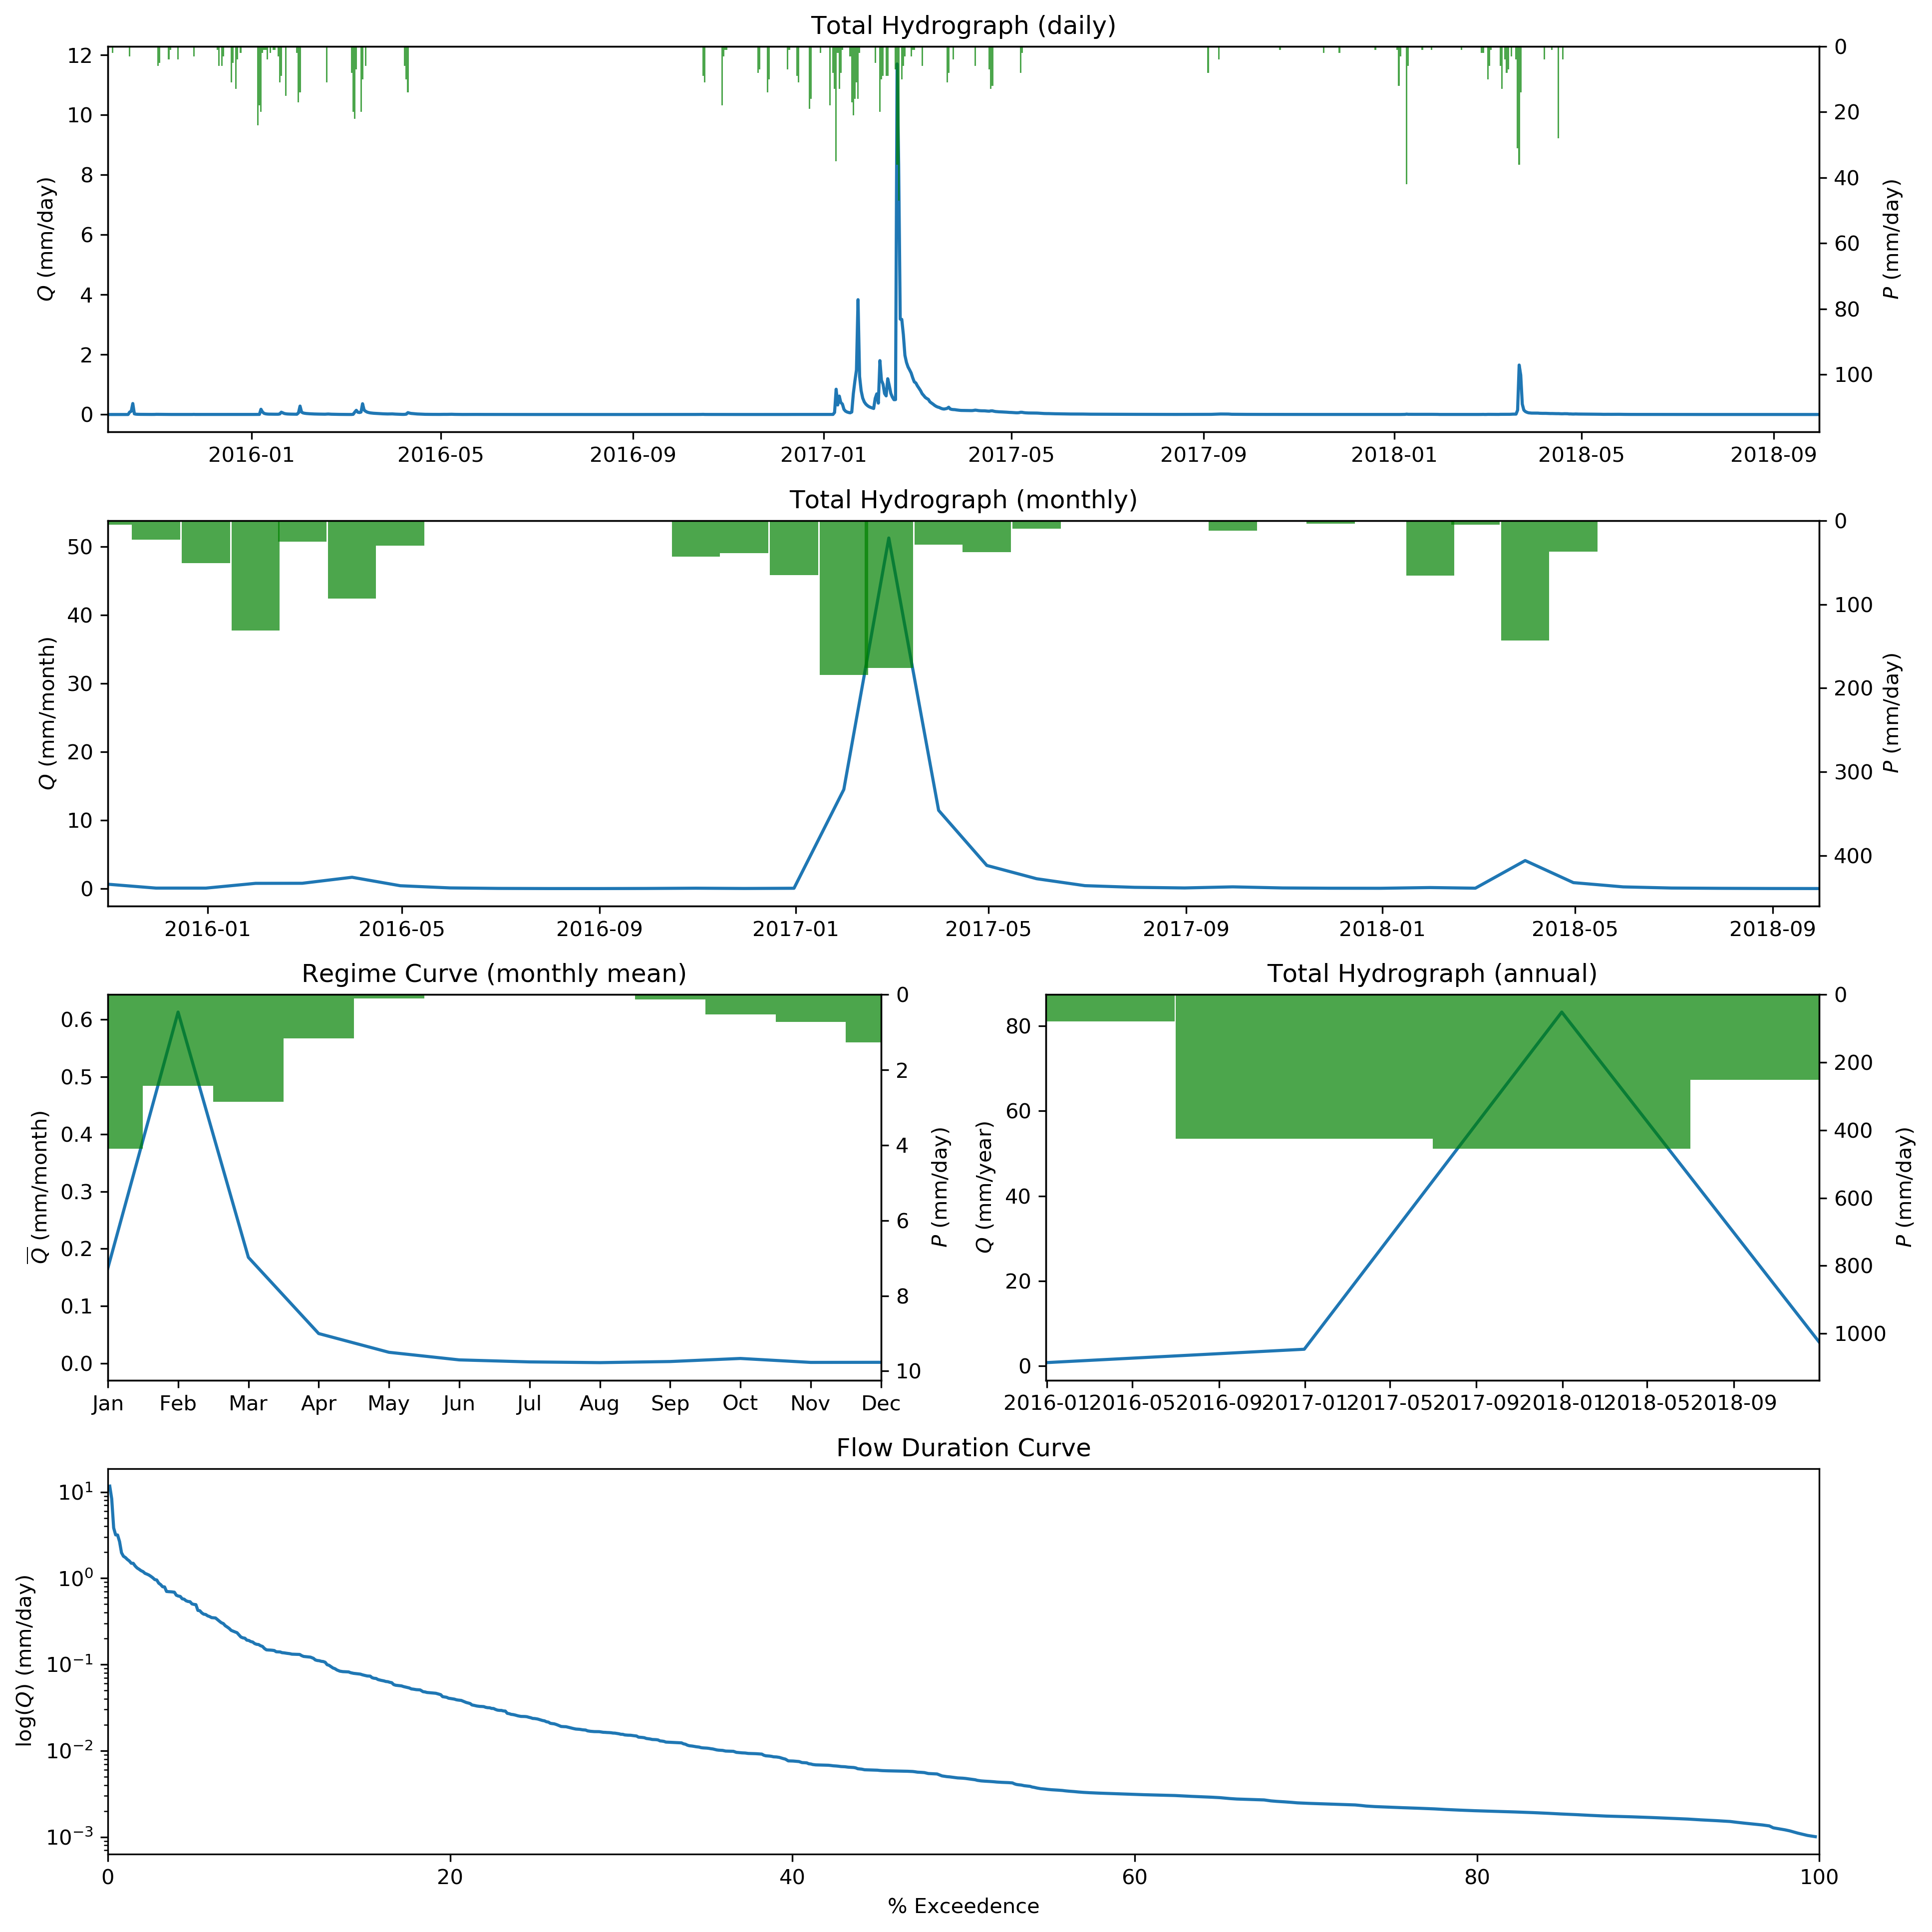

In [20]:
from hydrodata import plot as hydroplot

hydroplot.signatures({"Q": (Q['Q [m^3/s]'], wshed.drainage_area)}, P['P [mm/day]'])

The graphs above depict the timeseries of daily data as well as monthly and annual plots. Finally, it also includes a _Flow Duration Curve_ plot, which shows the percent of time that flow was above different thresholds from the highest to the lowest values. These curves give a sense of how dynamic a river basin is with respect to discharge as well as the distribution of flow amounts. Reading the x-axis of the flow duration curve, we can see that the 50% exceedence flow (i.e. the average amount of streamflow) is somewhere around 0.005 mm/day, which is very low. That corresponds to the fact that we only really see high flows in the Sisquoc during the 2017 water year, and only very small peaks in flow for the 2016 and 2018 water years. 


# 4. Your Assignment

Your assignment in this lab is to use the data we've just collected to assess the water balance of the Sisquoc River.  Each section of the Assignment is included below, with a summary of what you should do. We are not providing the code to do all of the calculations, but will show you the equations you need.


## 4.1 Assessing Basin Water Balance


### 4.1.0 Assign a water year for each entry in the `Q`, `ET`, and `P` dataframes.

<div class="practice">
    📚  <b> Question 4.1.1 </b> 
    Use the <code>water_year()</code> function that we created in Section 3.3.4 to create a new <code>water_year</code> column in the DataFrames for your three fluxes (Note: You may want – but are not required – to combine the three DataFrames into a single DataFrame that contains separate columns for <code>Q [mm/day]</code>, <code>P [mm/day]</code>, and <code>ET [mm/day]</code>.  
</div>

### 4.1.1 Convert Discharge to units of mm/day

<div class="data">
    📊 <b>Converting Unis of Q</b> The units of <code>Q</code> that you have are in cubic meters per second, while your units of <code>P</code> and <code>ET</code> are both in units of millimeters per day. You need to convert the <code>Q</code> values to mm/day. To do so, we need to figure out the discharge amount per unit area of the basin, which is converting the <i>flow</i> (amount per time) to a <i>flux</i> amount per time per unit area).
</div>

Here are some helpful conversions and their rationale:

1. There are 86,400 `seconds` in one `day`. Therefore:
$ 1 \frac{ \mbox{m}^3}{\mbox{second}} \mbox{water} = 86,400 \frac{ \mbox{kg}}{\mbox{day}} \mbox{water} $

1. Convert $1 \frac{ \mbox{m}^3}{\mbox{day}}$ of streamflow to depth by dividing by the basin area in m$^2$. (recall there are 1,000,000 m<sup>2</sup> per km<sup>2</sup>)


<div class="practice">
    📚  <b> Question 4.1.1. </b> 
    Use the conversions above to create a function that converts a streamflow in units of cubic meters per second into units of mm/day. Use the docstrings below to help make your function.
</div>

In [ ]:
def Q_mm(Q_cms, basin_area=None):
    """ Convert discharge in units of m^3/s into units of mm/day.
    
    # The lines below are a doctest. 
    # If your function is working correctly, you should get 86.4
    # when you call it using Q_mm(1, basin_area=1)
    
    >>> Q_mm(1, basin_area=1)
    86.4
    
    Parameters
    ----------
    
        Q_cms : float
            Streamflow in units of [m^3/s]
    
        basin_area : float
            Upstream area of basin at location of flow measurement, km^2
    
    Returns
    -------
        Q_mm : float
            Streamflow in units of mm/day
    
    
    
    """

    # Add your code here!

<div class="python">
    🐍 <b>Doctests.</b> 
    The <code>docstrings</code> in the cell above contain a <code>doctest</code>. A <code>doctest</code> is a portion of the <code>docstring</code> that begins with <code>>>></code>. This code can be run using the <code>doctest</code> module, which then checks to make sure that the result of the code is the same as the value in the line below the doctest string. In this case, the <doctest> would check to see that when we call <code>Q_mm(1, basin_area=1)</code>, the function returns <code>86.4</code> (the correct value). Doctests ensure that your code is doing what you want, and are a good way to check your functions.
</div>

We can run `doctest`s for any function in a Jupyter notebook by importing the `doctest` module and then using the `run_docstring_examples` method:
    
```python
import doctest
doctest.run_docstring_examples(Q_mm, globals(), verbose=True)
```


<div class="example">
    ✏️ <b> Try it. </b> 
    Once you've written your <code>Q_mm</code> function so it returns Q in mm/day, run the docstrings using the code above to make sure it works. 
</div>


### 4.1.2 Apply your `Q_mm` function to the `Q` dataframe to get a new column of `Q` in `mm/day`. 


<div class="practice">
    📚  <b> Question 4.1.2. </b> 
    Use the <code>apply</code> method and your <code>Q_mm</code> function to create a new column, <code>'Q [mm/day]'</code> that has values of streamflow in mm/day. 
</div>


### 4.1.3 Create a plot of the daily change in storage over the three water years.

Now that you have $Q$, $P$, and $ET$ all in the same units (mm/day), you can determine the daily change in storage:


$ \Delta S = P - ET - Q $


<div class="practice">
    📚  <b> Question 4.1.3. </b> 
    Create a new DataFrame with the change in storage and plot the data for the three water years.
</div>

### 4.1.4 Determine average monthly water balance


Use your measure of the change in storage to create a plot that contains the average monthly water balance across the three years of data. There will be one value of change in storage for each month of the water year. 


<div class="practice">
    📚  <b> Question 4.1.4. </b> 
    Use your measure of the change in storage to create a plot that contains the average monthly water balance across the three years of data. There will be one value of change in storage for each month of the water year.
</div>

### 4.1.5 Assess the degree to which this basin is in steady state


As discussed above, under steady-state conditions the change in storage, $\Delta S$, is zero and our equation reduces to:

$ P = ET + Q$

<div class="practice">
    📚  <b> Question 4.1.5. </b> 
   Use your three years of data to determine if this basin is in steady state over the entire time period.
</div>

### 4.1.6 Determine Basin Runoff Coefficients


The runoff ratio or runoff coefficient, $R_c$, is defined as the fraction of rainfall that leaves a basin through streamflow over a period of time. 

$ R_{c} = \frac{\sum{Q}}{\sum{P}} $

The runoff coefficient is larger value for areas with low infiltration and high runoff (pavement, steep gradient), and lower for permeable, well vegetated areas (forest, flat land). The ratio is important for flood control, channel construction, and for possible flood zone hazard delineation. A high $R_c$ value may indicate flash flooding areas during storms as water moves fast overland on its way to a river channel or a valley floor.


<div class="practice">
    📚  <b> Question 4.1.6.</b> 
   Calculate the runoff ratio for the months with the 5 highest rainfalls during the three year record.
</div>

## 4.2 Choose your own basin.


Use all of the example and assignment text to create an analysis of a USGS basin of your choosing. You can browse a map of all stream gauge locations in the US at the [maps.waterdata.usgs.gov](https://maps.waterdata.usgs.gov/mapper/index.html) site. Select a basin that is near a place you've lived, or a part of the country that you have visited or has some meaning to you. 


Your analysis should include:

1. A plot of the basin hydrography
1. A plot of the basin topography
1. A plot of average rainfall, streamflow and runoff ratio by month
1. A single year of waterbalance analysis. Note: Because obtaining ET data is slow, you should pick a single year between 2000 and 2018 to calculate your basin waterbalance. Use the `get_ET_wateryear()` function.


### Some Local Gauges of Possible Interest:

- [Carpinteria Creek](https://waterdata.usgs.gov/nwis/inventory/?site_no=11119500) in Carpinteria, Station ID 11119500

```pyton 
carpinteria_id = '11119500' 
```
- [Mission Creek](https://waterdata.usgs.gov/nwis/inventory/?site_no=11119750) in Santa Barbara, Station ID 11119750

```python
mission_id = '11119750'
```
- [Atascadero Creek](https://waterdata.usgs.gov/nwis/inventory/?site_no=11120000) in Goleta, Station ID 11120000

```python
atascadero_id = '11120000'
```



# 5. Extra Stuff: Land Use Data

While we don't use it in this lab, `hydrodata` also makes it possible to access land use and land cover data can be obtained from the Multi-Resolution Land Characteristics (MRLC) Consortium. By default the data are downloaded from NLCD 2016.

In [21]:
lulc = hds.nlcd(wshed.geometry, resolution=1)

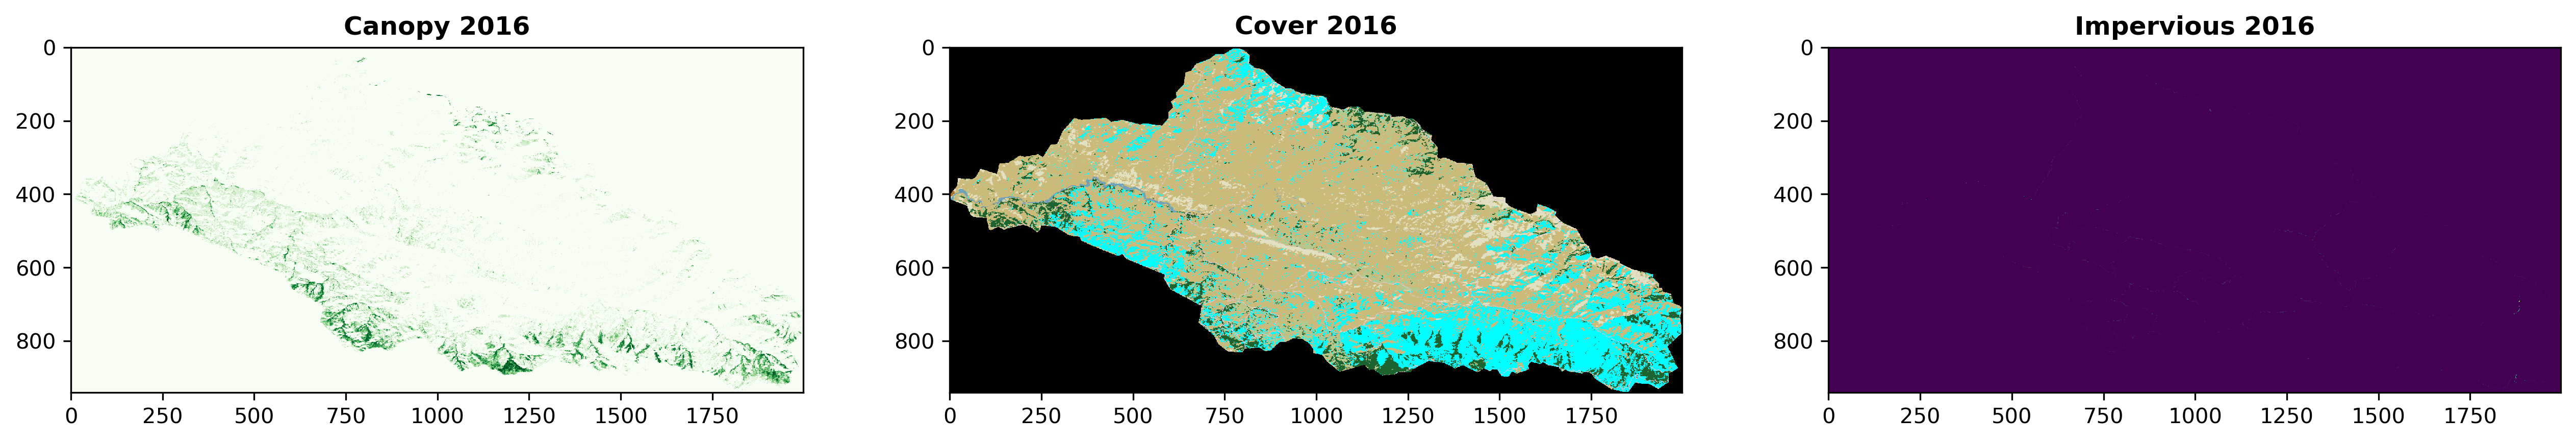

In [22]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

cmap, norm, levels = hydroplot.cover_legends()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7), dpi=300)
show(lulc['canopy'], ax=ax1, title=f'Canopy 2016', cmap='Greens')
show(lulc['cover'], ax=ax2, title=f'Cover 2016', cmap=cmap, norm=norm)
show(lulc['impervious'], ax=ax3, title=f'Impervious 2016');

<hr style="border-top: 1px solid gray; margin-top: 24px; margin-bottom: 1px"></hr>

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/exercises.css", "r").read()
    return HTML(styles)
css_styling()